In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import multimodal_vae
import torch_mvae_util as U
import util.RAVDESS_dataset_util as Rd
from train_mvae import build_model, train
from config_args import ConfigModelArgs, ConfigTrainArgs

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

In [4]:
au_dataset = pd.read_csv(cfg_model.dataset_path).to_numpy()

In [5]:
au = au_dataset[:,:-1]
emotions = au_dataset[:,-1].astype(int)-1
au_dataset = [(x, y) for x, y in zip(au, emotions)]

In [6]:
trainingset_len = len(au_dataset) // 100 * 70
testset_len = len(au_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    au_dataset, 
    [trainingset_len, testset_len],
    generator=torch.Generator().manual_seed(66)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  6930 
test set size:  2972


In [7]:
use_cuda = True

model_args = {
    'cat_dim' : cfg_model.cat_dim,
    'au_dim' : cfg_model.au_dim,
    'latent_space_dim' : cfg_model.z_dim,
    'hidden_dim' : cfg_model.hidden_dim,
    'num_filters' : cfg_model.num_filters,
    'modes' : cfg_model.modes,
    'expert_type' : cfg_model.expert_type,
    'use_cuda' : cfg_train.use_cuda
}
print(model_args)
train_args = {
    'learning_rate' : cfg_train.learning_rate,
    'optim_betas' : cfg_train.optim_betas,
    'num_epochs' : cfg_train.num_epochs,
    'batch_size' : cfg_train.batch_size
}
print(train_args)

{'cat_dim': 8, 'au_dim': 18, 'latent_space_dim': 50, 'hidden_dim': 128, 'num_filters': 32, 'modes': {'au': <config_args.Mode object at 0x7f6bc2fba680>, 'face': None, 'emotion': <config_args.Mode object at 0x7f6bc2fba7d0>}, 'expert_type': 'moe', 'use_cuda': True}
{'learning_rate': 1e-06, 'optim_betas': [0.95, 0.98], 'num_epochs': 1000, 'batch_size': 512}


In [8]:
model: torch.nn.Module = build_model(**model_args).double()

In [9]:
load_model = False

if load_model:    
    PATH = "../trained_models/fusion.save"
    loaded_data = torch.load(PATH)
    
    model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
    model.load_state_dict(loaded_data['model_params'])
    
    training_losses = loaded_data['training_loss']    
    model.eval()

In [10]:
train_model = True

if train_model:
    training_losses = train(
        mvae_model=model,
        dataset_loader=dataset_loader,
        learning_rate=cfg_train.learning_rate,
        optim_betas=cfg_train.optim_betas,
        num_epochs=cfg_train.num_epochs,
        seed=cfg_train.seed,
        use_cuda=cfg_train.use_cuda,
        cfg=cfg_train,
        checkpoint_every=cfg_train.checkpoint_every,
        resume_train = False
    )

100%|█████████████████████████████████████████████████████████████████| 1000/1000 [35:28<00:00,  2.13s/it]


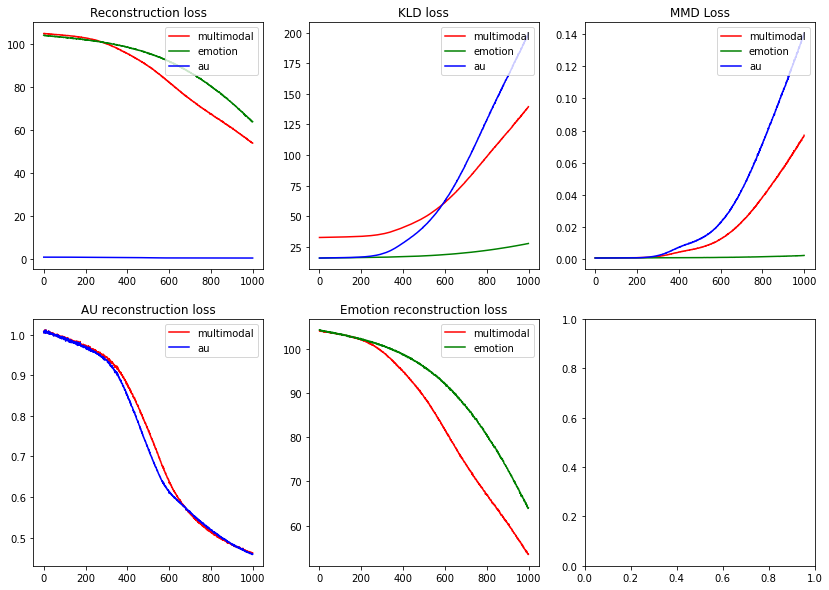

In [11]:
U.print_losses(training_losses)

In [12]:
save_model = True

if save_model:
    PATH = "../trained_models/au_emo.save"
    torch.save({#'rec_image' : rec_image,
                'model_args' : model_args,
                'training_loss' : training_losses,
                'train_args': train_args,
                'model_params' : model.state_dict()
               }, PATH)

In [13]:
labels = list(Rd.emocat.values())

100%|█████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 75.47it/s]
/home/studenti/ballerini/miniconda3/envs/rsa-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studenti/ballerini/miniconda3/envs/rsa-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studenti/ballerini/miniconda3/envs/rsa-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being se

              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       447
        calm       0.52      0.42      0.47       930
       happy       0.60      0.72      0.65       927
         sad       0.26      0.21      0.24       944
       angry       0.22      0.02      0.04       939
     fearful       0.27      0.67      0.38       917
     disgust       0.67      0.64      0.65       916
   surprised       0.19      0.21      0.20       910

    accuracy                           0.39      6930
   macro avg       0.34      0.36      0.33      6930
weighted avg       0.36      0.39      0.35      6930



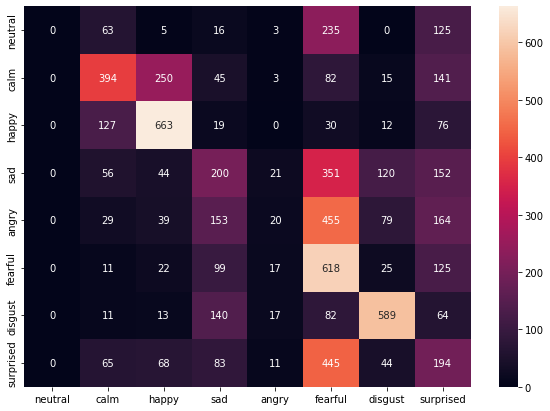

In [14]:
y_true, y_pred = U.au_classiffication_accuracy(model, dataset_loader)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 33.80it/s]
/home/studenti/ballerini/miniconda3/envs/rsa-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studenti/ballerini/miniconda3/envs/rsa-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studenti/ballerini/miniconda3/envs/rsa-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being se

              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       198
        calm       0.47      0.40      0.44       403
       happy       0.59      0.72      0.65       397
         sad       0.28      0.22      0.24       385
       angry       0.22      0.03      0.05       399
     fearful       0.27      0.67      0.38       384
     disgust       0.71      0.65      0.68       427
   surprised       0.21      0.24      0.22       379

    accuracy                           0.39      2972
   macro avg       0.34      0.37      0.33      2972
weighted avg       0.37      0.39      0.36      2972



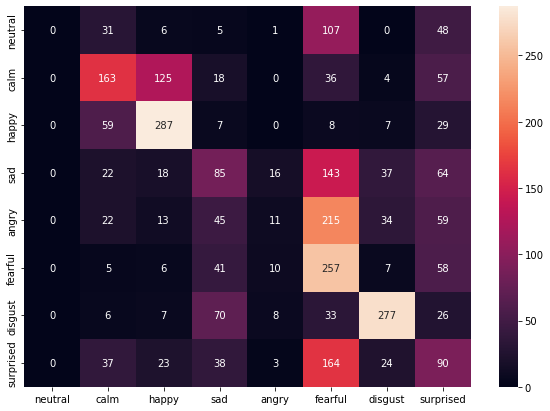

In [15]:
y_true, y_pred = U.au_classiffication_accuracy(model, testset_loader)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

100%|████████████████████████████████████████████████████████████████| 2048/2048 [00:03<00:00, 562.88it/s]
/home/studenti/ballerini/miniconda3/envs/rsa-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studenti/ballerini/miniconda3/envs/rsa-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studenti/ballerini/miniconda3/envs/rsa-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being se

              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00      4111
        calm       0.23      0.00      0.01      3956
       happy       0.00      0.00      0.00      4086
         sad       0.15      0.03      0.04      4131
       angry       0.14      0.01      0.01      4236
     fearful       0.14      0.68      0.23      4062
     disgust       0.00      0.00      0.00      4073
   surprised       0.12      0.34      0.18      4113

    accuracy                           0.13     32768
   macro avg       0.10      0.13      0.06     32768
weighted avg       0.10      0.13      0.06     32768



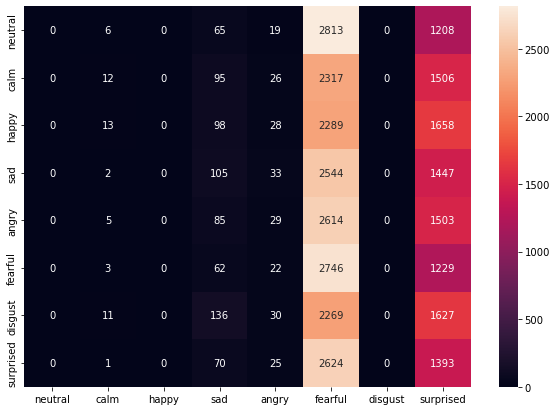

In [16]:
y_true, y_pred = U.au_recon_and_classiffication_accuracy(model, num_samples=2048)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)